In [1]:
import os
import re
import string
import requests
import numpy as np
import collections
import random
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
ops.reset_default_graph()
sess = tf.Session()
num_layers = 3
min_word_freq = 5
rnn_size = 128
epochs = 10
batch_size = 100
learning_rate = 0.0005
training_seq_len = 50
save_every = 500
eval_every = 50
prime_texts = ['thou art more', 'to be or not to', 'wherefore art thou']
data_dir = 'temp'
data_file = 'shakespeare.txt'
model_path = 'shakespeare_model'
full_model_dir = os.path.join(data_dir, model_path)
punctuation = string.punctuation
punctuation = ''.join([x for x in punctuation if x not in ['-', "'"]])

if not os.path.exists(full_model_dir):
    os.makedirs(full_model_dir)
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
if not os.path.isfile(os.path.join(data_dir, data_file)):
    print('Not found, downloading Shakespeare texts from www.gutenberg.org')
    shakespeare_url = 'http://www.gutenberg.org/cache/epub/100/pg100.txt'
    response = requests.get(shakespeare_url)
    shakespeare_file = response.content
    s_text = shakespeare_file.decode('utf-8')
    s_text = s_text[7675:]
    s_text = s_text.replace('\r\n', '')
    s_text = s_text.replace('\n', '')
    with open(os.path.join(data_dir, data_file), 'w') as out_conn:
        out_conn.write(s_text)
else:
    with open(os.path.join(data_dir, data_file), 'r') as file_conn:
        s_text = file_conn.read().replace('\n', '')

In [2]:
s_text = re.sub(r'[{}]'.format(punctuation), ' ', s_text)
s_text = re.sub('\s+', ' ', s_text ).strip().lower()
char_list = list(s_text)
def build_vocab(characters):
    character_counts = collections.Counter(characters)
    chars = character_counts.keys()
    vocab_to_ix_dict = {key:(ix+1) for ix, key in enumerate(chars)}
    vocab_to_ix_dict['unknown']=0
    ix_to_vocab_dict = {val:key for key,val in vocab_to_ix_dict.items()}
    return(ix_to_vocab_dict, vocab_to_ix_dict)
ix2vocab, vocab2ix = build_vocab(char_list)
vocab_size = len(ix2vocab)
print('Vocabulary Length = {}'.format(vocab_size))
assert(len(ix2vocab) == len(vocab2ix))
s_text_ix = []
for x in char_list:
    try:
        s_text_ix.append(vocab2ix[x])
    except:
        s_text_ix.append(0)
s_text_ix = np.array(s_text_ix)

Vocabulary Length = 40


In [3]:
class LSTM_Model():
    def __init__(self, rnn_size, num_layers, batch_size, learning_rate,
                 training_seq_len, vocab_size, infer_sample=False):
        self.rnn_size = rnn_size
        self.num_layers = num_layers
        self.vocab_size = vocab_size
        self.infer_sample = infer_sample
        self.learning_rate = learning_rate
        if infer_sample:
            self.batch_size = 1
            self.training_seq_len = 1
        else:
            self.batch_size = batch_size
            self.training_seq_len = training_seq_len
        self.lstm_cell = tf.contrib.rnn.BasicLSTMCell(rnn_size)
        self.lstm_cell = tf.contrib.rnn.MultiRNNCell([self.lstm_cell for _ in range(self.num_layers)])
        self.initial_state = self.lstm_cell.zero_state(self.batch_size, tf.float32)
        self.x_data = tf.placeholder(tf.int32, [self.batch_size, self.training_seq_len])
        self.y_output = tf.placeholder(tf.int32, [self.batch_size, self.training_seq_len])
        with tf.variable_scope('lstm_vars'):
            W = tf.get_variable('W', [self.rnn_size, self.vocab_size], tf.float32, tf.random_normal_initializer())
            b = tf.get_variable('b', [self.vocab_size], tf.float32, tf.constant_initializer(0.0))
            embedding_mat = tf.get_variable('embedding_mat', [self.vocab_size, self.rnn_size],
                                            tf.float32, tf.random_normal_initializer())
            embedding_output = tf.nn.embedding_lookup(embedding_mat, self.x_data)
            rnn_inputs = tf.split(axis=1, num_or_size_splits=self.training_seq_len, value=embedding_output)
            rnn_inputs_trimmed = [tf.squeeze(x, [1]) for x in rnn_inputs]
        decoder = tf.contrib.legacy_seq2seq.rnn_decoder
        outputs, last_state = decoder(rnn_inputs_trimmed,
                                      self.initial_state,
                                      self.lstm_cell)
        output = tf.reshape(tf.concat(axis=1, values=outputs), [-1, rnn_size])
        self.logit_output = tf.matmul(output, W) + b
        self.model_output = tf.nn.softmax(self.logit_output)
        loss_fun = tf.contrib.legacy_seq2seq.sequence_loss_by_example
        loss = loss_fun([self.logit_output],[tf.reshape(self.y_output, [-1])],
                [tf.ones([self.batch_size * self.training_seq_len])],
                self.vocab_size)
        self.cost = tf.reduce_sum(loss) / (self.batch_size * self.training_seq_len)
        self.final_state = last_state
        gradients, _ = tf.clip_by_global_norm(tf.gradients(self.cost, tf.trainable_variables()), 4.5)
        optimizer = tf.train.AdamOptimizer(self.learning_rate)
        self.train_op = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))
    def sample(self, sess, words=ix2vocab, vocab=vocab2ix, num=20, prime_text='thou art'):
        state = sess.run(self.lstm_cell.zero_state(1, tf.float32))
        char_list = list(prime_text)
        for char in char_list[:-1]:
            x = np.zeros((1, 1))
            x[0, 0] = vocab[char]
            feed_dict = {self.x_data: x, self.initial_state:state}
            [state] = sess.run([self.final_state], feed_dict=feed_dict)
        out_sentence = prime_text
        char = char_list[-1]
        for n in range(num):
            x = np.zeros((1, 1))
            x[0, 0] = vocab[char]
            feed_dict = {self.x_data: x, self.initial_state:state}
            [model_output, state] = sess.run([self.model_output, self.final_state], feed_dict=feed_dict)
            sample = np.argmax(model_output[0])
            if sample == 0:
                break
            char = words[sample]
            out_sentence = out_sentence + char
        return(out_sentence)

lstm_model = LSTM_Model(rnn_size, num_layers, batch_size, learning_rate,
                        training_seq_len, vocab_size)
with tf.variable_scope(tf.get_variable_scope(), reuse=True):
    test_lstm_model = LSTM_Model(rnn_size,num_layers, batch_size, learning_rate,
                                 training_seq_len, vocab_size, infer_sample=True)

saver = tf.train.Saver(tf.global_variables())
num_batches = int(len(s_text_ix)/(batch_size * training_seq_len)) + 1
batches = np.array_split(s_text_ix, num_batches)
batches = [np.resize(x, [batch_size, training_seq_len]) for x in batches]

init = tf.global_variables_initializer()
sess.run(init)
train_loss = []
iteration_count = 1
for epoch in range(epochs):
    random.shuffle(batches)
    targets = [np.roll(x, -1, axis=1) for x in batches]
    print('Starting Epoch #{} of {}.'.format(epoch+1, epochs))
    state = sess.run(lstm_model.initial_state)
    for ix, batch in enumerate(batches):
        training_dict = {lstm_model.x_data: batch, lstm_model.y_output: targets[ix]}
        for i, (c, h) in enumerate(lstm_model.initial_state):
                    training_dict[c] = state[i].c
                    training_dict[h] = state[i].h
        temp_loss, state, _ = sess.run([lstm_model.cost, lstm_model.final_state, lstm_model.train_op],
                                       feed_dict=training_dict)
        train_loss.append(temp_loss)
        if iteration_count % 10 == 0:
            summary_nums = (iteration_count, epoch+1, ix+1, num_batches+1, temp_loss)
            print('Iteration: {}, Epoch: {}, Batch: {} out of {}, Loss: {:.2f}'.format(*summary_nums))
        if iteration_count % save_every == 0:
            model_file_name = os.path.join(full_model_dir, 'model')
            saver.save(sess, model_file_name, global_step = iteration_count)
            print('Model Saved To: {}'.format(model_file_name))
            dictionary_file = os.path.join(full_model_dir, 'vocab.pkl')
            with open(dictionary_file, 'wb') as dict_file_conn:
                pickle.dump([vocab2ix, ix2vocab], dict_file_conn)
        iteration_count += 1

Starting Epoch #1 of 10.
Iteration: 10, Epoch: 1, Batch: 10 out of 950, Loss: 3.06
Iteration: 20, Epoch: 1, Batch: 20 out of 950, Loss: 2.90
Iteration: 30, Epoch: 1, Batch: 30 out of 950, Loss: 2.88
Iteration: 40, Epoch: 1, Batch: 40 out of 950, Loss: 2.85
Iteration: 50, Epoch: 1, Batch: 50 out of 950, Loss: 2.86
Iteration: 60, Epoch: 1, Batch: 60 out of 950, Loss: 2.85
Iteration: 70, Epoch: 1, Batch: 70 out of 950, Loss: 2.81
Iteration: 80, Epoch: 1, Batch: 80 out of 950, Loss: 2.81
Iteration: 90, Epoch: 1, Batch: 90 out of 950, Loss: 2.85
Iteration: 100, Epoch: 1, Batch: 100 out of 950, Loss: 2.79
Iteration: 110, Epoch: 1, Batch: 110 out of 950, Loss: 2.76
Iteration: 120, Epoch: 1, Batch: 120 out of 950, Loss: 2.72
Iteration: 130, Epoch: 1, Batch: 130 out of 950, Loss: 2.73
Iteration: 140, Epoch: 1, Batch: 140 out of 950, Loss: 2.74
Iteration: 150, Epoch: 1, Batch: 150 out of 950, Loss: 2.62
Iteration: 160, Epoch: 1, Batch: 160 out of 950, Loss: 2.63
Iteration: 170, Epoch: 1, Batch: 

Iteration: 1360, Epoch: 2, Batch: 411 out of 950, Loss: 1.87
Iteration: 1370, Epoch: 2, Batch: 421 out of 950, Loss: 1.88
Iteration: 1380, Epoch: 2, Batch: 431 out of 950, Loss: 1.92
Iteration: 1390, Epoch: 2, Batch: 441 out of 950, Loss: 1.90
Iteration: 1400, Epoch: 2, Batch: 451 out of 950, Loss: 1.92
Iteration: 1410, Epoch: 2, Batch: 461 out of 950, Loss: 1.91
Iteration: 1420, Epoch: 2, Batch: 471 out of 950, Loss: 1.88
Iteration: 1430, Epoch: 2, Batch: 481 out of 950, Loss: 1.88
Iteration: 1440, Epoch: 2, Batch: 491 out of 950, Loss: 1.99
Iteration: 1450, Epoch: 2, Batch: 501 out of 950, Loss: 1.87
Iteration: 1460, Epoch: 2, Batch: 511 out of 950, Loss: 1.78
Iteration: 1470, Epoch: 2, Batch: 521 out of 950, Loss: 1.90
Iteration: 1480, Epoch: 2, Batch: 531 out of 950, Loss: 1.93
Iteration: 1490, Epoch: 2, Batch: 541 out of 950, Loss: 1.94
Iteration: 1500, Epoch: 2, Batch: 551 out of 950, Loss: 1.82
Model Saved To: temp\shakespeare_model\model
Iteration: 1510, Epoch: 2, Batch: 561 ou

Iteration: 2680, Epoch: 3, Batch: 782 out of 950, Loss: 1.77
Iteration: 2690, Epoch: 3, Batch: 792 out of 950, Loss: 1.81
Iteration: 2700, Epoch: 3, Batch: 802 out of 950, Loss: 1.78
Iteration: 2710, Epoch: 3, Batch: 812 out of 950, Loss: 1.86
Iteration: 2720, Epoch: 3, Batch: 822 out of 950, Loss: 1.75
Iteration: 2730, Epoch: 3, Batch: 832 out of 950, Loss: 1.69
Iteration: 2740, Epoch: 3, Batch: 842 out of 950, Loss: 1.78
Iteration: 2750, Epoch: 3, Batch: 852 out of 950, Loss: 1.74
Iteration: 2760, Epoch: 3, Batch: 862 out of 950, Loss: 1.70
Iteration: 2770, Epoch: 3, Batch: 872 out of 950, Loss: 1.75
Iteration: 2780, Epoch: 3, Batch: 882 out of 950, Loss: 1.72
Iteration: 2790, Epoch: 3, Batch: 892 out of 950, Loss: 1.73
Iteration: 2800, Epoch: 3, Batch: 902 out of 950, Loss: 1.74
Iteration: 2810, Epoch: 3, Batch: 912 out of 950, Loss: 1.71
Iteration: 2820, Epoch: 3, Batch: 922 out of 950, Loss: 1.83
Iteration: 2830, Epoch: 3, Batch: 932 out of 950, Loss: 1.74
Iteration: 2840, Epoch: 

Model Saved To: temp\shakespeare_model\model
Iteration: 4010, Epoch: 5, Batch: 214 out of 950, Loss: 1.66
Iteration: 4020, Epoch: 5, Batch: 224 out of 950, Loss: 1.70
Iteration: 4030, Epoch: 5, Batch: 234 out of 950, Loss: 1.74
Iteration: 4040, Epoch: 5, Batch: 244 out of 950, Loss: 1.61
Iteration: 4050, Epoch: 5, Batch: 254 out of 950, Loss: 1.67
Iteration: 4060, Epoch: 5, Batch: 264 out of 950, Loss: 1.72
Iteration: 4070, Epoch: 5, Batch: 274 out of 950, Loss: 1.67
Iteration: 4080, Epoch: 5, Batch: 284 out of 950, Loss: 1.72
Iteration: 4090, Epoch: 5, Batch: 294 out of 950, Loss: 1.59
Iteration: 4100, Epoch: 5, Batch: 304 out of 950, Loss: 1.75
Iteration: 4110, Epoch: 5, Batch: 314 out of 950, Loss: 1.70
Iteration: 4120, Epoch: 5, Batch: 324 out of 950, Loss: 1.69
Iteration: 4130, Epoch: 5, Batch: 334 out of 950, Loss: 1.67
Iteration: 4140, Epoch: 5, Batch: 344 out of 950, Loss: 1.69
Iteration: 4150, Epoch: 5, Batch: 354 out of 950, Loss: 1.76
Iteration: 4160, Epoch: 5, Batch: 364 ou

Iteration: 5330, Epoch: 6, Batch: 585 out of 950, Loss: 1.71
Iteration: 5340, Epoch: 6, Batch: 595 out of 950, Loss: 1.66
Iteration: 5350, Epoch: 6, Batch: 605 out of 950, Loss: 1.65
Iteration: 5360, Epoch: 6, Batch: 615 out of 950, Loss: 1.67
Iteration: 5370, Epoch: 6, Batch: 625 out of 950, Loss: 1.59
Iteration: 5380, Epoch: 6, Batch: 635 out of 950, Loss: 1.61
Iteration: 5390, Epoch: 6, Batch: 645 out of 950, Loss: 1.58
Iteration: 5400, Epoch: 6, Batch: 655 out of 950, Loss: 1.63
Iteration: 5410, Epoch: 6, Batch: 665 out of 950, Loss: 1.72
Iteration: 5420, Epoch: 6, Batch: 675 out of 950, Loss: 1.60
Iteration: 5430, Epoch: 6, Batch: 685 out of 950, Loss: 1.67
Iteration: 5440, Epoch: 6, Batch: 695 out of 950, Loss: 1.68
Iteration: 5450, Epoch: 6, Batch: 705 out of 950, Loss: 1.60
Iteration: 5460, Epoch: 6, Batch: 715 out of 950, Loss: 1.70
Iteration: 5470, Epoch: 6, Batch: 725 out of 950, Loss: 1.68
Iteration: 5480, Epoch: 6, Batch: 735 out of 950, Loss: 1.61
Iteration: 5490, Epoch: 

Starting Epoch #8 of 10.
Iteration: 6650, Epoch: 8, Batch: 7 out of 950, Loss: 1.63
Iteration: 6660, Epoch: 8, Batch: 17 out of 950, Loss: 1.56
Iteration: 6670, Epoch: 8, Batch: 27 out of 950, Loss: 1.53
Iteration: 6680, Epoch: 8, Batch: 37 out of 950, Loss: 1.63
Iteration: 6690, Epoch: 8, Batch: 47 out of 950, Loss: 1.58
Iteration: 6700, Epoch: 8, Batch: 57 out of 950, Loss: 1.61
Iteration: 6710, Epoch: 8, Batch: 67 out of 950, Loss: 1.63
Iteration: 6720, Epoch: 8, Batch: 77 out of 950, Loss: 1.62
Iteration: 6730, Epoch: 8, Batch: 87 out of 950, Loss: 1.64
Iteration: 6740, Epoch: 8, Batch: 97 out of 950, Loss: 1.62
Iteration: 6750, Epoch: 8, Batch: 107 out of 950, Loss: 1.62
Iteration: 6760, Epoch: 8, Batch: 117 out of 950, Loss: 1.61
Iteration: 6770, Epoch: 8, Batch: 127 out of 950, Loss: 1.69
Iteration: 6780, Epoch: 8, Batch: 137 out of 950, Loss: 1.61
Iteration: 6790, Epoch: 8, Batch: 147 out of 950, Loss: 1.66
Iteration: 6800, Epoch: 8, Batch: 157 out of 950, Loss: 1.61
Iteration:

Iteration: 7980, Epoch: 9, Batch: 388 out of 950, Loss: 1.58
Iteration: 7990, Epoch: 9, Batch: 398 out of 950, Loss: 1.51
Iteration: 8000, Epoch: 9, Batch: 408 out of 950, Loss: 1.55
Model Saved To: temp\shakespeare_model\model
Iteration: 8010, Epoch: 9, Batch: 418 out of 950, Loss: 1.51
Iteration: 8020, Epoch: 9, Batch: 428 out of 950, Loss: 1.58
Iteration: 8030, Epoch: 9, Batch: 438 out of 950, Loss: 1.65
Iteration: 8040, Epoch: 9, Batch: 448 out of 950, Loss: 1.57
Iteration: 8050, Epoch: 9, Batch: 458 out of 950, Loss: 1.64
Iteration: 8060, Epoch: 9, Batch: 468 out of 950, Loss: 1.68
Iteration: 8070, Epoch: 9, Batch: 478 out of 950, Loss: 1.59
Iteration: 8080, Epoch: 9, Batch: 488 out of 950, Loss: 1.61
Iteration: 8090, Epoch: 9, Batch: 498 out of 950, Loss: 1.71
Iteration: 8100, Epoch: 9, Batch: 508 out of 950, Loss: 1.73
Iteration: 8110, Epoch: 9, Batch: 518 out of 950, Loss: 1.60
Iteration: 8120, Epoch: 9, Batch: 528 out of 950, Loss: 1.60
Iteration: 8130, Epoch: 9, Batch: 538 ou

Iteration: 9290, Epoch: 10, Batch: 749 out of 950, Loss: 1.58
Iteration: 9300, Epoch: 10, Batch: 759 out of 950, Loss: 1.52
Iteration: 9310, Epoch: 10, Batch: 769 out of 950, Loss: 1.67
Iteration: 9320, Epoch: 10, Batch: 779 out of 950, Loss: 1.51
Iteration: 9330, Epoch: 10, Batch: 789 out of 950, Loss: 1.65
Iteration: 9340, Epoch: 10, Batch: 799 out of 950, Loss: 1.64
Iteration: 9350, Epoch: 10, Batch: 809 out of 950, Loss: 1.46
Iteration: 9360, Epoch: 10, Batch: 819 out of 950, Loss: 1.60
Iteration: 9370, Epoch: 10, Batch: 829 out of 950, Loss: 1.45
Iteration: 9380, Epoch: 10, Batch: 839 out of 950, Loss: 1.60
Iteration: 9390, Epoch: 10, Batch: 849 out of 950, Loss: 1.54
Iteration: 9400, Epoch: 10, Batch: 859 out of 950, Loss: 1.57
Iteration: 9410, Epoch: 10, Batch: 869 out of 950, Loss: 1.56
Iteration: 9420, Epoch: 10, Batch: 879 out of 950, Loss: 1.54
Iteration: 9430, Epoch: 10, Batch: 889 out of 950, Loss: 1.55
Iteration: 9440, Epoch: 10, Batch: 899 out of 950, Loss: 1.53
Iteratio

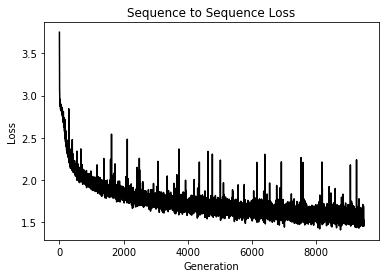

In [4]:
plt.plot(train_loss, 'k-')
plt.title('Sequence to Sequence Loss')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()